- This Jupyter notebook contains the code setup for extracting the vector embeddings for the training dataset. We used *Word2vec* for extracting the vector embeddings.
- Along with that, we also performed Feature Engineering & Exploratory Data Analysis (EDA) on the training dataset, came up with some insights on how to deal with the dataset.
- Then also wrote the code for *model training* & *hyperparameter-tuning*.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 

In [2]:
## Loading the dataset
df = pd.read_csv('train.csv')
df.head()

,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


In [3]:
## Checking for null values
df.isnull().sum()

sample_id          0
catalog_content    0
image_link         0
price              0
dtype: int64

In [4]:
## Checking for duplicated values
df.duplicated().sum()

0

### Code with a Smart IPQ Parser

- Here, we're trying to extract *key features* from the 'catalog_content'
    - product_name → Extracted from “Item Name:” section.

    - product_description → Formed by joining all bullet points.

    - quantity and unit → Extracted using smart regex (e.g., “500 ml” → 500, milliliter)

The idea is to clean & normalize units so different spellings (like “ml”, “mililitro”) become one standard form (like milliliter)

In [ ]:
import pandas as pd
import re
import numpy as np

# 1. Define Unit Normalization Mappings
UNIT_ALIASES = {
    'count': ['count', 'ct', 'each', 'pack', 'packs', 'piece', 'units', 'capsule'],
    'ounce': ['ounce', 'ounces', 'oz'],
    'fluid_ounce': ['fl', 'fluid'],
    'pound': ['pound', 'pounds', 'lb'],
    'gram': ['gram', 'grams', 'gr', 'gramm'],
    'kilogram': ['kg', 'kilogram'],
    'liter': ['liter', 'liters', 'ltr'],
    'milliliter': ['ml', 'milliliter', 'millilitre', 'mililitro']
}
NORMALIZED_UNIT_MAP = {alias: standard_name for standard_name, aliases in UNIT_ALIASES.items() for alias in aliases}
ALL_UNITS_REGEX = '|'.join(NORMALIZED_UNIT_MAP.keys())


# 2. Create the Smarter IPQ Parsing Function 
def parse_and_clean_ipq(text):
    """
    Intelligently extracts and normalizes quantity and unit from text.
    """
    value_unit_match = re.search(r'Value:\s*([\d.]+)\s*Unit:\s*(\w+)', text, flags=re.IGNORECASE)
    if value_unit_match:
        try:
            found_unit = value_unit_match.group(2).lower()
            if found_unit in NORMALIZED_UNIT_MAP:
                return float(value_unit_match.group(1)), NORMALIZED_UNIT_MAP[found_unit]
        except (ValueError, TypeError):
            pass

    general_match = re.search(r'(\d*\.?\d+)\s*\-?\s*(' + ALL_UNITS_REGEX + r')\b', text, flags=re.IGNORECASE)
    if general_match:
        try:
            return float(general_match.group(1)), NORMALIZED_UNIT_MAP[general_match.group(2).lower()]
        except (ValueError, TypeError):
            pass

    return np.nan, 'unknown'


# 3. Update the Main Feature Extraction Function (With Fallback Logic)
def extract_product_details_with_fallback(df):
    """
    The main function with robust extractors and a fallback for the description.
    """
    # Step 1: Extract Product Name (This must be done first)
    df['product_name'] = df['catalog_content'].str.extract(
        r'Item Name:(.*?)(?=Bullet Point \d+:|Value:|$)', flags=re.DOTALL
    )[0].fillna('').str.strip()
    
    # Step 2: Extract Description from Bullet Points
    def combine_bullets_final(content):
        bullets = re.findall(r'Bullet Point \d+:(.*?)(?=Bullet Point \d+:|Value:|$)', content, flags=re.DOTALL)
        if not bullets:
            return "" # Return empty string if no bullets are found
        return ' '.join([bullet.strip() for bullet in bullets if bullet.strip()])

    df['product_description'] = df['catalog_content'].apply(combine_bullets_final)

    # *** THE FALLBACK LOGIC ***
    # Find rows where the description is still an empty string
    empty_desc_mask = df['product_description'] == ''
    
    # For those rows, we will set the description to be the product name
    df.loc[empty_desc_mask, 'product_description'] = df.loc[empty_desc_mask, 'product_name']

    # Extract IPQ
    ipq_data = df['catalog_content'].apply(lambda x: pd.Series(parse_and_clean_ipq(x)))
    df[['quantity', 'unit']] = ipq_data
    df['quantity'] = df['quantity'].fillna(0)
    df['unit'] = df['unit'].fillna('unknown')
    
    return df

# Apply the final, fully corrected function
df_processed = extract_product_details_with_fallback(df.copy())

# Proof of the Fix
print("Fallback logic applied.")

# Check for any remaining empty descriptions (should be 0)
empty_descriptions_after_fix = (df_processed['product_description'] == '').sum()
print(f"Number of empty descriptions after fix: {empty_descriptions_after_fix}")


Fallback logic applied.
Number of empty descriptions after fix: 5


### Removing the 5 rows with no description

In [6]:
empty_list = []
index_list = []
for i in range(df_processed.shape[0]):
    if(df_processed['product_description'][i] == ''):
        empty_list.append(df_processed['sample_id'][i])
        index_list.append(i)

print(empty_list)
print(index_list)

[105358, 272962, 161437, 161436, 94863]
[41520, 50513, 50543, 55110, 74234]


In [7]:
df_processed.drop(index=[41520, 50513, 50543, 55110, 74234], inplace=True)

In [8]:
df_processed.head(1)

,sample_id,catalog_content,image_link,price,product_name,product_description,quantity,unit
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...","La Victoria Green Taco Sauce Mild, 12 Ounce (P...",72.0,fluid_ounce


In [9]:
df_processed['unit'].unique()

array(['fluid_ounce', 'ounce', 'count', 'pound', 'unknown', 'gram',
       'liter', 'milliliter', 'kilogram'], dtype=object)

### Feature Engineering Techniques

 We will use *Basic Text Statistics* for this part. Creating 3 new features:
 - name_length: no. of characters in *product_name*
 - desc_word_count: Number of words in the *product_description*
 - desc_uniqueness: Ratio of unique words to total words in the description.
    

In [10]:
df_processed['name_length'] = df_processed['product_name'].str.len()
df_processed['desc_word_count'] = df_processed['product_description'].str.split().str.len()
df_processed['desc_uniqueness'] = df_processed['product_description'].apply(lambda x: len(set(x.split())) / (len(x.split()) + 1e-6))

In [11]:
df_processed.head(1)

,sample_id,catalog_content,image_link,price,product_name,product_description,quantity,unit,name_length,desc_word_count,desc_uniqueness
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...","La Victoria Green Taco Sauce Mild, 12 Ounce (P...",72.0,fluid_ounce,55,11,1.0


In [12]:
df_processed.isnull().sum()

sample_id              0
catalog_content        0
image_link             0
price                  0
product_name           0
product_description    0
quantity               0
unit                   0
name_length            0
desc_word_count        0
desc_uniqueness        0
dtype: int64

In [13]:
list = [df_processed['unit'].unique()]
print(list)

[array(['fluid_ounce', 'ounce', 'count', 'pound', 'unknown', 'gram',
       'liter', 'milliliter', 'kilogram'], dtype=object)]


### Standardizing the Units

- To compare products, their quantities must be in the same unit. So, we will create a single, standardized quantity column.

In [14]:
def standardize_units_and_value(df, quantity_col='quantity', unit_col='unit'):
   
    # Conversion factors to standard units (kg for mass, L for volume)
    conversion_map = {
        # Mass to Kilograms (kg)
        'ounce': 0.0283495,
        'pound': 0.453592,
        'gram': 0.001,
        'kilogram': 1.0,
        
        # Volume to Liters (L)
        'fluid_ounce': 0.0295735,
        'milliliter': 0.001,
        'liter': 1.0
    }
    
    # Function to apply to each row
    def convert_row(row):
  
        unit = str(row[unit_col]).lower()
        
        if unit in conversion_map:
            # Get the conversion factor
            factor = conversion_map[unit]
            
            # Calculate the new quantity
            new_quantity = row[quantity_col] * factor
            
            # Determining the new standard unit
            new_unit = 'kg' if unit in ['ounce', 'pound', 'gram', 'kilogram'] else 'L'
            
            return new_quantity, new_unit
        else:
            # If the unit is not in the map (e.g., 'count', 'unknown'), return the original values
            return row[quantity_col], row[unit_col]

    # We will apply the function and create new columns and expand the result into two new columns
    df[['standardized_quantity', 'standardized_unit']] = df.apply(convert_row, axis=1, result_type='expand')
    
    return df

In [15]:
df_processed = standardize_units_and_value(df_processed)

In [16]:
df_processed.head(1)

,sample_id,catalog_content,image_link,price,product_name,product_description,quantity,unit,name_length,desc_word_count,desc_uniqueness,standardized_quantity,standardized_unit
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...","La Victoria Green Taco Sauce Mild, 12 Ounce (P...",72.0,fluid_ounce,55,11,1.0,2.129292,L


### Dropping *quantity* & *unit*

In [17]:
df_processed.drop(columns=['quantity', 'unit'], inplace=True)

### Exploratory Data Analysis (EDA)

### Generating ranges for the *'price'* feature

- $ 50-100 
- $ 100-150
- $ 150-200
- $ 200+

In [18]:
cnt50 = (df_processed['price']<=50).sum()
cnt100 = (df_processed['price']<=100).sum() - cnt50
cnt150 = (df_processed['price']<=150).sum() - (cnt100 + cnt50)  
cnt200 = (df_processed['price']<=200).sum() - (cnt150 + cnt100 + cnt50)
cntmax = (df_processed['price']>200).sum()

print(f"Cnt50:{cnt50}  Cnt100:{cnt100}  Cnt150:{cnt150}  Cnt200:{cnt200}  Cnt200+:{cntmax}")

Cnt50:66903  Cnt100:6199  Cnt150:1222  Cnt200:373  Cnt200+:298


#### Plotting the **bar plot** for the price distribution

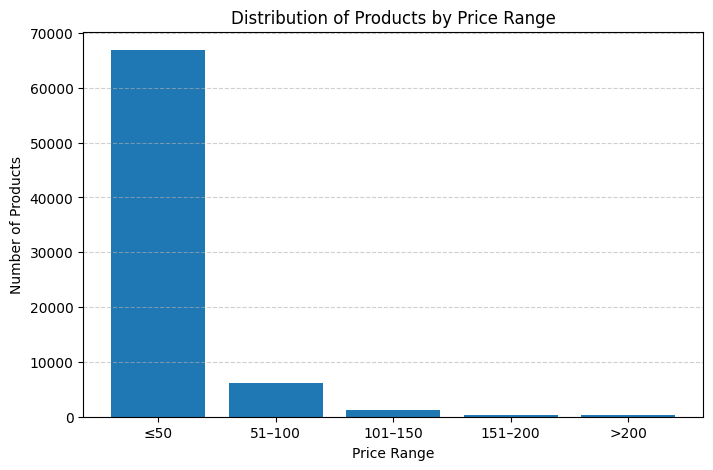

In [19]:
price_ranges = ['≤50', '51–100', '101–150', '151–200', '>200']
counts = [cnt50, cnt100, cnt150, cnt200, cntmax]

# Plot
plt.figure(figsize=(8,5))
plt.bar(price_ranges, counts)
plt.xlabel('Price Range')
plt.ylabel('Number of Products')
plt.title('Distribution of Products by Price Range')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Insights

- There are only 298 values of *price* which lies above 200$... so we will be dropping those values.

In [20]:
df_processed = df_processed[df_processed['price'] < 200]

In [21]:
df_processed.describe().T

,count,mean,std,min,25%,50%,75%,max
sample_id,74697.0,149836.021072,86629.227477,0.000000,73792.000000,150048.000000,225089.000000,299438.00
price,74697.0,22.508269,25.196702,0.130000,6.790000,13.990000,28.280000,199.99
name_length,74697.0,120.601015,166.757286,0.000000,56.000000,79.000000,139.000000,6378.00
desc_word_count,74697.0,119.521614,126.588598,1.000000,23.000000,74.000000,168.000000,1282.00
desc_uniqueness,74697.0,0.785577,0.155939,0.196429,0.675079,0.791045,0.914634,1.00
standardized_quantity,74697.0,11.150733,79.135760,0.000000,0.340194,0.946352,3.000000,6000.00


### Insights

- The dataset is skewed as the std of the price is quite *high* with std of 25.196702 & min of 0.1300000

### Heatmap --> To identify the correlation between between the features

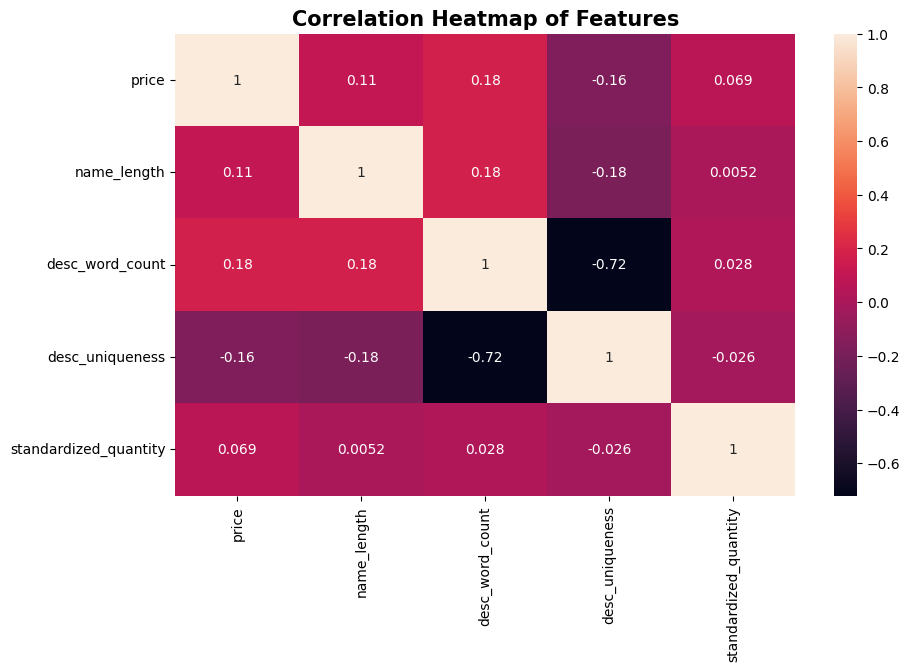

In [22]:
plt.figure(figsize=[10, 6])
sns.heatmap(data=df_processed[['price',
       'name_length', 'desc_word_count',
       'desc_uniqueness', 'standardized_quantity']].corr(), annot=True)
plt.title("Correlation Heatmap of Features", fontsize=15, weight='bold')
plt.show()

### Insights

- There's no strong correlation between the features. So we can keep the features.

### Boxplot --> To detect outliers

Text(0.5, 1.0, 'standardized quantity')

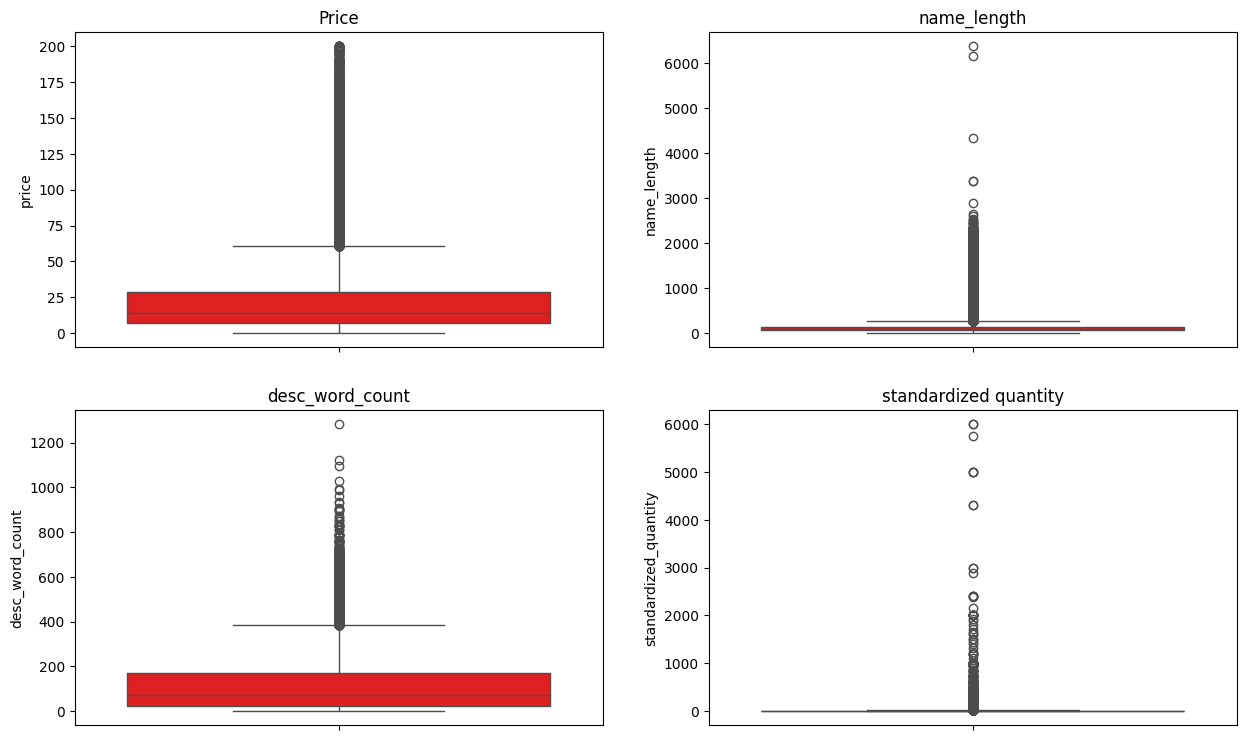

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))

## Plot 1: Price
sns.boxplot(y=df_processed['price'], ax=axs[0, 0], color='r')
axs[0, 0].set_title('Price')

## Plot 2: name_length
sns.boxplot(y=df_processed['name_length'], ax=axs[0, 1], color='r')
axs[0, 1].set_title('name_length')


## Plot 3: desc_word_count
sns.boxplot(y=df_processed['desc_word_count'], ax=axs[1, 0], color='r')
axs[1, 0].set_title('desc_word_count')

## Plot 4: standardized_quantity
sns.boxplot(y=df_processed['standardized_quantity'], ax=axs[1, 1], color='r')
axs[1, 1].set_title('standardized quantity')



### Insights

- The dataset exhibits a significant number of outliers, which can be attributed to the inherent characteristics of its underlying distribution rather than data quality issues.

### Histograms

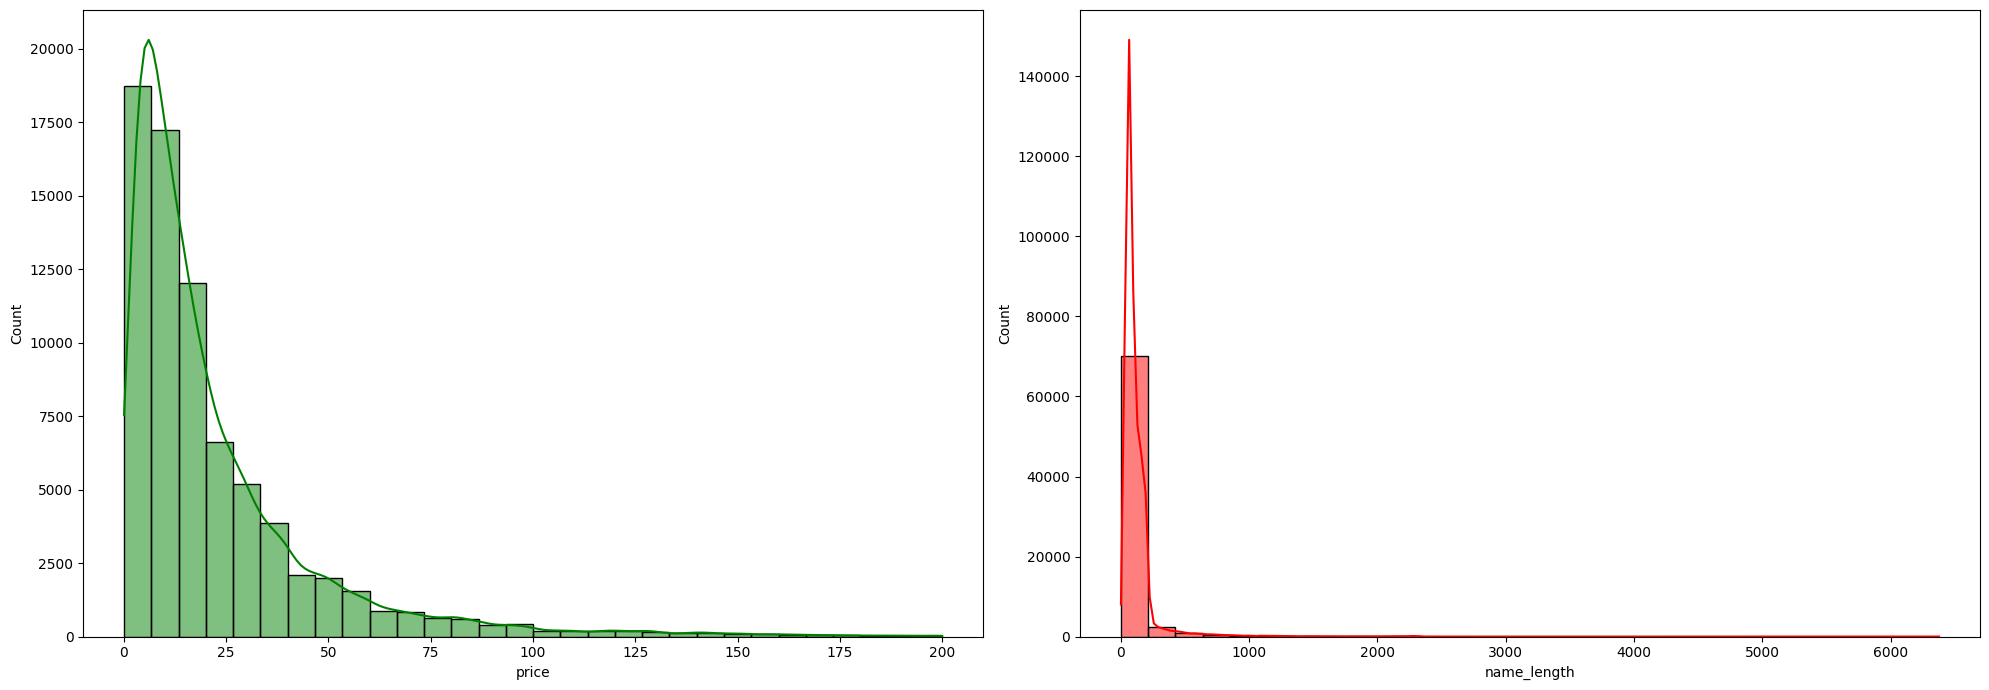

In [24]:
fig, axs = plt.subplots(1, 2, figsize=[20,7])
plt.subplot(1,2,1)
sns.histplot(data=df_processed['price'], bins=30, kde=True, color='g')
plt.subplot(1,2,2)
sns.histplot(data=df_processed['name_length'], bins=30, kde=True, color='r')
plt.tight_layout()
plt.show()

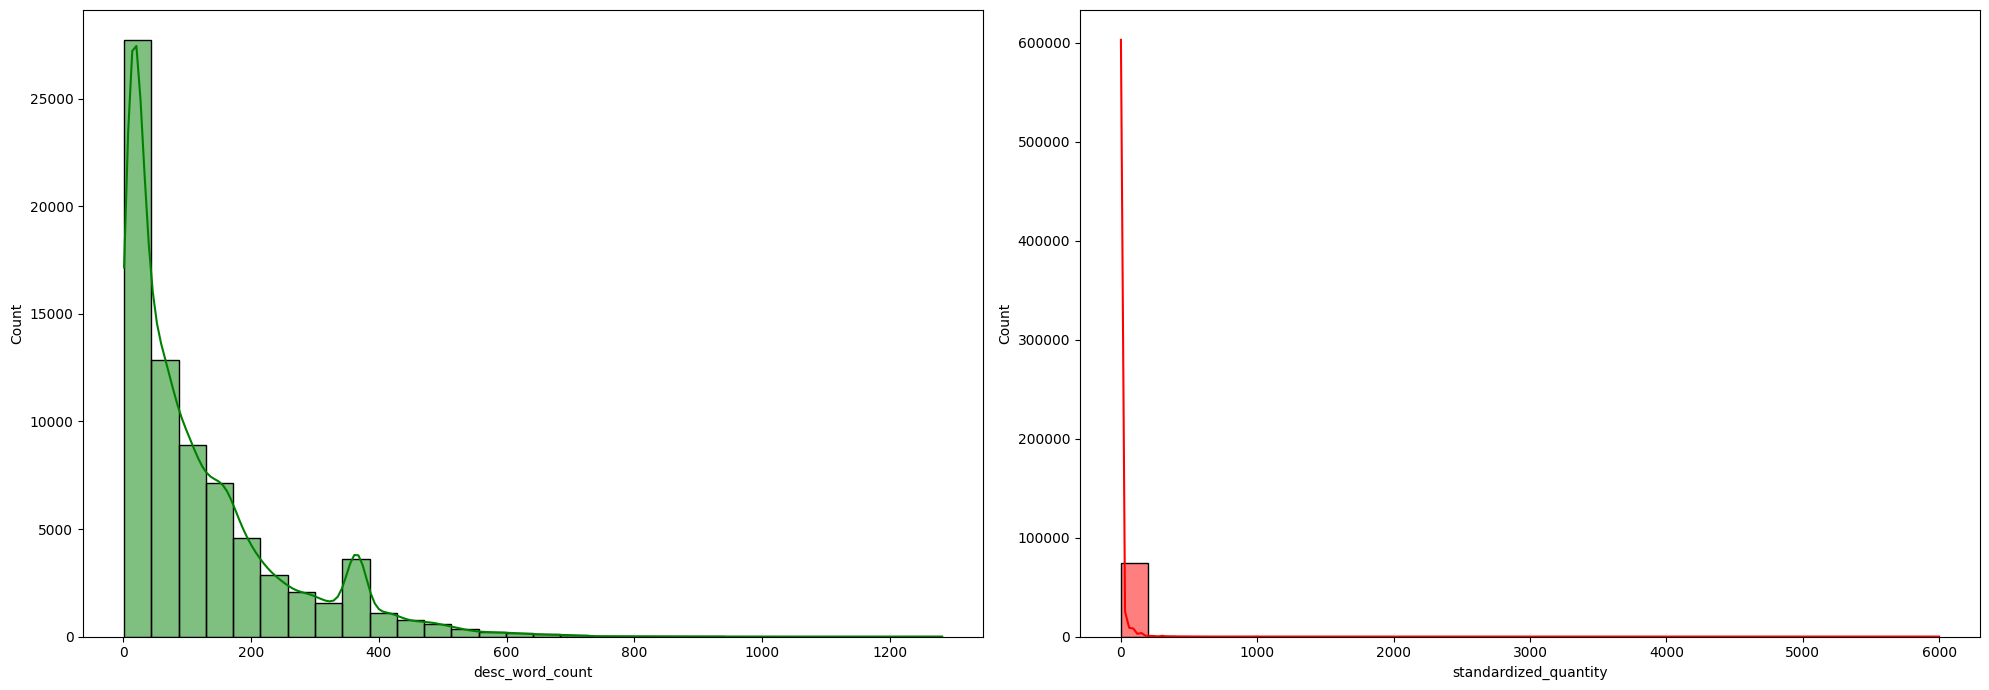

In [25]:
fig, axs = plt.subplots(1, 2, figsize=[20,7])
plt.subplot(1,2,1)
sns.histplot(data=df_processed['desc_word_count'], bins=30, kde=True, color='g')
plt.subplot(1,2,2)
sns.histplot(data=df_processed['standardized_quantity'], bins=30, kde=True, color='r')
plt.tight_layout()
plt.show()

### Insights
- The dataset is a lot skewed. So we will have to apply 'Log-Transformation' to change the distribution of the 'Normal-distribution'.

# Violinplot

- A violin plot is used to visualize the distribution, density, and probability density function (PDF) of a dataset, combining aspects of a box plot and a kernel density plot.

Text(0.5, 1.0, 'standardized quantity')

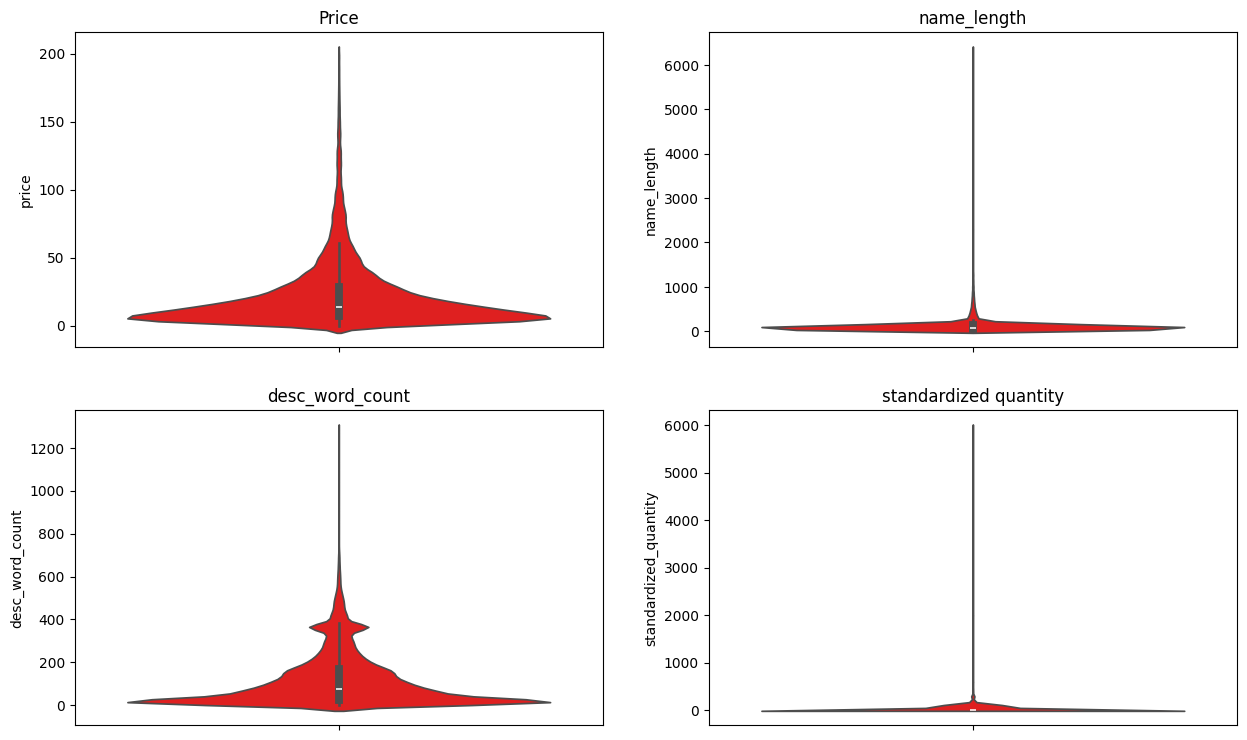

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))

## Plot 1: Price
sns.violinplot(y=df_processed['price'], ax=axs[0, 0], color='r')
axs[0, 0].set_title('Price')

## Plot 2: name_length
sns.violinplot(y=df_processed['name_length'], ax=axs[0, 1], color='r')
axs[0, 1].set_title('name_length')


## Plot 3: desc_word_count
sns.violinplot(y=df_processed['desc_word_count'], ax=axs[1, 0], color='r')
axs[1, 0].set_title('desc_word_count')

## Plot 4: standardized_quantity
sns.violinplot(y=df_processed['standardized_quantity'], ax=axs[1, 1], color='r')
axs[1, 1].set_title('standardized quantity')



### Creating a copy dataframe --> we will use it while creating final text embedding

In [27]:
df_copy = df_processed.copy()

In [28]:
df_copy.shape

(74697, 11)

### Checking for skew

In [29]:
df_processed['price'].skew()

2.6677187703124536

In [30]:
df_processed['name_length'].skew()

8.56845479246146

In [31]:
df_processed['desc_word_count'].skew()

1.5981161313909173

In [32]:
df_processed['standardized_quantity'].skew()

40.3164736439453

### Applying Log Transformation on the columns

In [33]:
skewed_features = ['name_length', 'desc_word_count', 'price', 'standardized_quantity'] # Add 'quantity' if you haven't already

print("Skewness before transformation:")
print(df_processed[skewed_features].skew())

# Apply the log transformation, creating new columns
for feature in skewed_features:
    df_processed[f'{feature}_log'] = np.log1p(df_processed[feature])


df_processed = df_processed.drop(columns=skewed_features)

print("\nSkewness after transformation:")
print(df_processed[[f'{feature}_log' for feature in skewed_features]].skew())

Skewness before transformation:
name_length               8.568455
desc_word_count           1.598116
price                     2.667719
standardized_quantity    40.316474
dtype: float64

Skewness after transformation:
name_length_log              0.901795
desc_word_count_log         -0.210996
price_log                    0.122944
standardized_quantity_log    1.835720
dtype: float64


In [34]:
df_processed.head(1)

,sample_id,catalog_content,image_link,product_name,product_description,desc_uniqueness,standardized_unit,name_length_log,desc_word_count_log,price_log,standardized_quantity_log
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...","La Victoria Green Taco Sauce Mild, 12 Ounce (P...",1.0,L,4.025352,2.484907,1.773256,1.140807


Text(0.5, 1.0, 'standardized quantity')

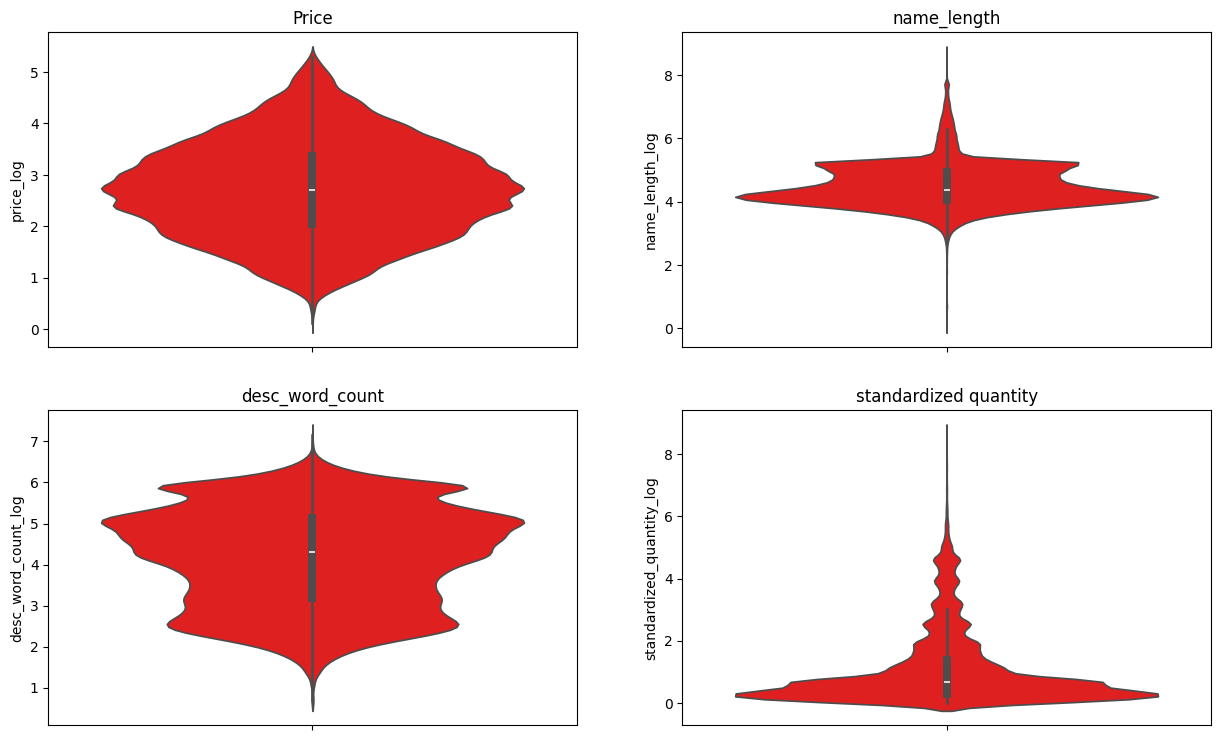

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))

## Plot 1: Price
sns.violinplot(y=df_processed['price_log'], ax=axs[0, 0], color='r')
axs[0, 0].set_title('Price')

## Plot 2: name_length
sns.violinplot(y=df_processed['name_length_log'], ax=axs[0, 1], color='r')
axs[0, 1].set_title('name_length')


## Plot 3: desc_word_count
sns.violinplot(y=df_processed['desc_word_count_log'], ax=axs[1, 0], color='r')
axs[1, 0].set_title('desc_word_count')

## Plot 4: standardized_quantity
sns.violinplot(y=df_processed['standardized_quantity_log'], ax=axs[1, 1], color='r')
axs[1, 1].set_title('standardized quantity')



### Insights
- The skewness is finally reduced.

### Dropping *sample_id*, *image_link* & *product_name* columns

In [36]:
df_processed.drop(columns=['sample_id', 'catalog_content', 'image_link', 'product_name'], inplace=True)

In [37]:
X = df_processed.drop(columns=['price_log'])
y = df_processed['price_log']

In [38]:
X.shape, y.shape

((74697, 6), (74697,))

### Label Encoding the *unit* column

In [39]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
X['standardized_unit'] = encoder.fit_transform(X['standardized_unit'])

#### Applying NLP preprocessing --> tokenization, removing stopwords, applying Stemming (SnowballStemmer)

In [40]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# NLTK downloads 
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Initializing the stemmer and get the list of stop words (in English)
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

# Loading the Word2Vec model 
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
def tokenize_stem_and_filter(text: str):
    """
    This function takes raw text and performs the following:
    1. Converts to lowercase.
    2. Removes punctuation and numbers.
    3. Tokenizes the text into words.
    4. Removes common English stop words.
    5. Stems each word to its root form.
    
    Returns a list of processed tokens.
    """
    if not isinstance(text, str):
        return []
    
    # Lowercase and remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Filter stop words and apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    return stemmed_tokens

#### Converting the textual data (product_description) into *word embeddings*

- Approach 1: Using Word2Vec

In [42]:
X.columns

Index(['product_description', 'desc_uniqueness', 'standardized_unit',
       'name_length_log', 'desc_word_count_log', 'standardized_quantity_log'],
      dtype='object')

In [ ]:
from tqdm import tqdm
def create_document_vector(tokens, model):
    """
    This function averages the word vectors for a given list of tokens.
    Uses the trained Word2Vec model to look up vectors.
    """

    vectors = [model.wv[word] for word in tokens if word in model.wv.key_to_index]
    
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
        
    # else return the mean of the vectors
    return np.mean(vectors, axis=0)

# Process Text and Train Word2Vec Model

# Preparing Text for Word2Vec
print("Processing product descriptions...")

processed_descriptions = [tokenize_stem_and_filter(text) for text in tqdm(X['product_description'].dropna())]

# Training the Word2Vec Model
print("\nTraining Word2Vec model...")

w2v_model = Word2Vec(
    sentences=processed_descriptions,
    vector_size=200,  # Number of dimensions of the word vectors.
    window=5,         
    min_count=2,      
    workers=4         # We want 4 worker threads to train the model (for faster training).
)
print("Word2Vec model trained!")

# We will create Document Vectors
print("\nCreating document vectors from descriptions...")
# We reuse the 'processed_descriptions' we already created, which is much faster.
X_embed = np.array([create_document_vector(tokens, w2v_model) for tokens in processed_descriptions])

# Combine All Features
other_features = X[['desc_uniqueness', 'standardized_unit',
       'name_length_log', 'desc_word_count_log', 'standardized_quantity_log']].values

X_full_final = np.hstack([X_embed, other_features])

print("\n Final matrix created successfully!")
print(f"Shape of the final training data matrix: {X_full_final.shape}")

Processing product descriptions...


100%|██████████| 74697/74697 [01:14<00:00, 1008.76it/s]



Training Word2Vec model...
Word2Vec model trained!

Creating document vectors from descriptions...

 Final matrix created successfully!
Shape of the final training data matrix: (74697, 205)


In [44]:
X_full_final.shape

(74697, 205)

#### Combining again the *X_full_final* & *sample_id* 

- 1. It's crucial to use the sample_id to ensure alignment.
- 2. We will create generic column names for the embeddings like 'embed_0', 'embed_1', etc.

In [ ]:
embedding_df = pd.DataFrame(
    X_full_final,
    index=df_copy['sample_id'], 
    columns=[f'embed_{i}' for i in range(X_full_final.shape[1])]
)

embedding_df.to_csv('text_embeddings_with_id_1.csv')

print("Successfully created DataFrame with sample_id as the index!")
print("Shape of the final DataFrame:", embedding_df.shape)
print("\nHere's a preview of the resulting DataFrame:")
display(embedding_df.head())

Successfully created DataFrame with sample_id as the index!
Shape of the final DataFrame: (74697, 205)

Here's a preview of the resulting DataFrame:


,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_195,embed_196,embed_197,embed_198,embed_199,embed_200,embed_201,embed_202,embed_203,embed_204
sample_id,,,,,,,,,,,,,,,,,,,,,
33127,0.963969,-0.234558,-0.891123,0.278710,-0.228415,-0.173354,-0.199584,0.475186,0.169390,0.239324,...,0.228262,0.460562,-0.019308,0.154796,0.169524,1.000000,0.0,4.025352,2.484907,1.140807
198967,0.361704,-0.074094,0.479006,0.088742,-0.921549,0.437950,0.803793,0.012174,0.206794,-0.240881,...,-0.088174,-0.063470,0.305092,0.918222,0.500419,0.833333,2.0,4.189655,3.891820,0.645628
261251,0.922279,0.173080,-0.651337,0.449624,-0.184846,0.009645,-0.525985,-0.080359,-0.946186,-0.663839,...,-0.302684,0.022264,0.598229,-0.168290,0.156379,0.958333,2.0,4.343805,3.218876,0.280041
55858,0.594004,-0.073018,0.095617,0.324928,-0.169563,0.248584,-0.315406,0.296498,-0.180882,-0.253597,...,0.175218,0.317277,0.595326,0.624045,-0.161947,0.716049,2.0,5.036953,5.093750,0.276822
292686,0.534727,-0.231619,-1.049262,-0.094552,-0.102085,0.228347,0.354384,0.322832,-0.513224,-0.629552,...,0.160560,1.070899,0.001087,-0.591283,-0.008825,0.545455,1.0,4.787492,3.135494,2.564949


#### Splitting the data into training and test set


In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full_final, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape

((59757, 205), (14940, 205))

### Evaluation Metric: SMAPE Function

- let's define the competition's evaluation metric, SMAPE, so we can use it for all our models.

In [47]:
def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

In [48]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

In [49]:
models = {
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(random_state=42, verbosity=-1, n_jobs=-1),
    "Extra Trees": ExtraTreesRegressor(random_state=42, n_jobs=-1),
}

model_list = []
smape_list = []

for model_name, model in tqdm(models.items(), desc="Training Models"):
    # The model fitting is now inside the progress bar loop
    model.fit(X_train, y_train)

    # Make Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    model_train_smape = smape(y_train, y_train_pred)
    model_test_smape = smape(y_test, y_test_pred)
    
    # Print the results for each model
    print(f"\n--- Results for {model_name} ---")
    print(f"  - Training SMAPE: {model_train_smape:.4f}%")
    print(f"  - Test SMAPE: {model_test_smape:.4f}%")
    print('='*35)
    
    model_list.append(model_name)
    smape_list.append(model_test_smape)

print("\nAll models trained successfully!")

Training Models:  17%|█▋        | 1/6 [04:05<20:28, 245.66s/it]


--- Results for Random Forest ---
  - Training SMAPE: 8.9951%
  - Test SMAPE: 22.1557%


Training Models:  33%|███▎      | 2/6 [16:51<36:45, 551.42s/it]


--- Results for Gradient Boosting ---
  - Training SMAPE: 23.7911%
  - Test SMAPE: 23.9918%


Training Models:  50%|█████     | 3/6 [17:14<15:31, 310.42s/it]


--- Results for CatBoost ---
  - Training SMAPE: 18.6968%
  - Test SMAPE: 21.9283%


Training Models:  67%|██████▋   | 4/6 [17:18<06:18, 189.40s/it]


--- Results for XGBoost ---
  - Training SMAPE: 16.6561%
  - Test SMAPE: 22.5101%


c:\Users\Amit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Amit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Training Models:  83%|████████▎ | 5/6 [17:20<02:01, 121.84s/it]


--- Results for LightGBM ---
  - Training SMAPE: 21.4029%
  - Test SMAPE: 22.7203%


Training Models: 100%|██████████| 6/6 [18:09<00:00, 181.66s/it]


--- Results for Extra Trees ---
  - Training SMAPE: 0.0582%
  - Test SMAPE: 21.8151%

All models trained successfully!


In [50]:
# The corrected code
results_df = pd.DataFrame(zip(model_list, smape_list), columns=['Model Name', 'SMAPE']).sort_values(by=['SMAPE'], ascending=True)


In [51]:
results_df

,Model Name,SMAPE
5,Extra Trees,21.815075
2,CatBoost,21.928308
0,Random Forest,22.155718
3,XGBoost,22.510057
4,LightGBM,22.720308
1,Gradient Boosting,23.991829


Top 3 models - 
- CatBoost 
- LightGBM
- XGBoost

Random Forest & Extra Trees are *overfitting*

#### Performing Hyperparameter tuning on the selected models

In [52]:
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer


# Create a scorer for cross-validation. Optuna minimizes, so lower is better.
smape_scorer = make_scorer(smape, greater_is_better=False)

# 1. Defining the Objective Function 
def objective(trial):
    """
    This function defines a single optimization trial.
    Optuna will call this function multiple times.
    """
    # First, choose which model to evaluate
    model_name = trial.suggest_categorical("model", ["CatBoost", "LightGBM", "XGBoost"])

    # Define the hyperparameter search space for each model
    if model_name == "CatBoost":
        params = {
            'iterations': trial.suggest_int('iterations', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'depth': trial.suggest_int('depth', 4, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
            'verbose': 0,
            'random_state': 42
        }
        model = CatBoostRegressor(**params)

    elif model_name == "LightGBM":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 10.0, log=True),
            'n_jobs': -1,
            'random_state': 42,
            'verbosity': -1
        }
        model = LGBMRegressor(**params)

    else: # XGBoost
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 1e-2, 10.0, log=True),
            'n_jobs': -1,
            'random_state': 42
        }
        model = XGBRegressor(**params)

    # Evaluate the model using cross-validation for robustness
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    # Use a simple loop for cross-validation to get SMAPE correctly
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        score = smape(y_val_fold, preds)
        scores.append(score)

    # Return the average SMAPE across the folds
    return np.mean(scores)

# The direction is 'minimize' because our goal is to get the lowest SMAPE
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10) # Run 10 trials, shall increase the trials if required

# 3. Print the Best Results
print("\n Optuna Study Finished!")
print(f"Number of finished trials: {len(study.trials)}")
print("Best trial:")
trial = study.best_trial

print(f"  Value (SMAPE): {trial.value:.4f}%")
print("  Best Parameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-10-13 13:41:48,379] A new study created in memory with name: no-name-5a88d7c3-bc36-4cc0-9151-8ba4d2f38e26
c:\Users\Amit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Amit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Amit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-10-13 13:42:25,669] Trial 0 finished with value: 22.800947355255783 and parameters: {'model': 'LightGBM', 'n_estimators': 633, 'learning_rate': 0.008347646531908424, 'num_leaves': 83, 'max_depth': 8, 'subsample': 0.


 Optuna Study Finished!
Number of finished trials: 10
Best trial:
  Value (SMAPE): 21.7653%
  Best Parameters: 
    model: LightGBM
    n_estimators: 1491
    learning_rate: 0.04731805900104831
    num_leaves: 245
    max_depth: 5
    subsample: 0.9441251328415233
    colsample_bytree: 0.8218406718984885
    reg_alpha: 7.550026548321983
    reg_lambda: 2.99380335826926


[I 2025-10-13 08:03:50,758] A new study created in memory with name: no-name-f8a60603-47c1-4d3f-b7b7-360fbd72ce2d
[I 2025-10-13 08:06:33,863] Trial 0 finished with value: 22.069055775864324 and parameters: {'model': 'XGBoost', 'n_estimators': 1521, 'learning_rate': 0.08351444050395146, 'max_depth': 11, 'subsample': 0.6926442356017577, 'colsample_bytree': 0.6171747153986598, 'gamma': 0.03705185845183536}. Best is trial 0 with value: 22.069055775864324.
c:\Users\Amit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Amit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Amit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-10-13 08:07:48,004] Trial 1 finished with value: 22.453330239911352 and parameters: {'model': 'LightGBM', 'n_estimators': 1794, 'learning_rate': 0.005734340080994751, 'num_leaves': 54, 'max_depth': 9, 'subsample': 0.7675677035305097, 'colsample_bytree': 0.810014248177176, 'reg_alpha': 0.06310845310077963, 'reg_lambda': 5.575717259207811}. Best is trial 0 with value: 22.069055775864324.
[I 2025-10-13 08:08:20,560] Trial 2 finished with value: 22.4971136102772 and parameters: {'model': 'XGBoost', 'n_estimators': 720, 'learning_rate': 0.06490787969468947, 'max_depth': 4, 'subsample': 0.7692538943761598, 'colsample_bytree': 0.9827397881222438, 'gamma': 0.0716004802098202}. Best is trial 0 with value: 22.069055775864324.
[I 2025-10-13 08:09:39,696] Trial 3 finished with value: 22.230015316201513 and parameters: {'model': 'XGBoost', 'n_estimators': 1604, 'learning_rate': 0.05501229331160283, 'max_depth': 12, 'subsample': 0.7894143094453392, 'colsample_bytree': 0.8871987624725102, 'gamma': 2.0073370874317957}. Best is trial 0 with value: 22.069055775864324.
[I 2025-10-13 08:10:17,617] Trial 4 finished with value: 22.407009805696006 and parameters: {'model': 'XGBoost', 'n_estimators': 863, 'learning_rate': 0.053907524078774895, 'max_depth': 8, 'subsample': 0.8660831189013825, 'colsample_bytree': 0.9307705053551384, 'gamma': 3.5507192826887217}. Best is trial 0 with value: 22.069055775864324.
[I 2025-10-13 08:13:11,924] Trial 5 finished with value: 24.854070331536715 and parameters: {'model': 'CatBoost', 'iterations': 1698, 'learning_rate': 0.0019211801988708922, 'depth': 7, 'subsample': 0.7618187531237917, 'colsample_bylevel': 0.6295164235611236, 'min_data_in_leaf': 89}. Best is trial 0 with value: 22.069055775864324.
c:\Users\Amit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Amit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Amit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-10-13 08:14:08,447] Trial 6 finished with value: 21.468125470672277 and parameters: {'model': 'LightGBM', 'n_estimators': 1976, 'learning_rate': 0.05299999569824112, 'num_leaves': 59, 'max_depth': 9, 'subsample': 0.7880082792637843, 'colsample_bytree': 0.6571400468794618, 'reg_alpha': 0.386132421661319, 'reg_lambda': 0.6003580555209204}. Best is trial 6 with value: 21.468125470672277.
[I 2025-10-13 08:24:50,336] Trial 7 finished with value: 21.61179381727207 and parameters: {'model': 'XGBoost', 'n_estimators': 1762, 'learning_rate': 0.01755928784906327, 'max_depth': 12, 'subsample': 0.7846378509519428, 'colsample_bytree': 0.9014334860951843, 'gamma': 0.02348024711729654}. Best is trial 6 with value: 21.468125470672277.
[I 2025-10-13 08:35:56,550] Trial 8 finished with value: 23.850540101151676 and parameters: {'model': 'CatBoost', 'iterations': 1056, 'learning_rate': 0.004509119563415654, 'depth': 10, 'subsample': 0.9428198434324554, 'colsample_bylevel': 0.8510315885660726, 'min_data_in_leaf': 30}. Best is trial 6 with value: 21.468125470672277.
[I 2025-10-13 08:43:32,978] Trial 9 finished with value: 23.730475607129602 and parameters: {'model': 'CatBoost', 'iterations': 1514, 'learning_rate': 0.004126745005821597, 'depth': 9, 'subsample': 0.7671222539480655, 'colsample_bylevel': 0.8637110535725283, 'min_data_in_leaf': 35}. Best is trial 6 with value: 21.468125470672277.

- Optuna Study Finished! 
Number of finished trials: 10
Best trial:
  Value (SMAPE): 21.4681%
  Best Parameters: 
    model: LightGBM
    n_estimators: 1976
    learning_rate: 0.05299999569824112
    num_leaves: 59
    max_depth: 9
    subsample: 0.7880082792637843
    colsample_bytree: 0.6571400468794618
    reg_alpha: 0.386132421661319
    reg_lambda: 0.6003580555209204

<!-- Trial 0 finished with value: 58.51358601256891 and parameters: {'model': 'LightGBM', 'n_estimators': 1119, 'learning_rate': 0.02842534009548026, 'num_leaves': 103, 'max_depth': 11, 'subsample': 0.908753956721506, 'colsample_bytree': 0.609444384039941, 'reg_alpha': 0.13872741337562605, 'reg_lambda': 1.4359344184282385}. Best is trial 0 with value: 58.51358601256891 -->